# Data prep

* Representations of 1854 concepts with 49 features
* Generate correlation matrix

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import re, seaborn as sns

data_dir = '../data'
output_dir = '../outputs'

In [2]:
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [35]:
temp = abs(np.corrcoef(original_embeddings, rowvar=False))
temp.min()

8.642178505132961e-05

In [42]:
(1-abs(temp.T + temp)/2)

array([[0.00000000e+00, 5.57049722e-01, 5.20574492e-01, ...,
        8.81469323e-01, 9.95511654e-01, 9.71687058e-01],
       [5.57049722e-01, 1.11022302e-16, 9.29811866e-01, ...,
        9.35101383e-01, 9.85698043e-01, 9.55508052e-01],
       [5.20574492e-01, 9.29811866e-01, 0.00000000e+00, ...,
        9.32713439e-01, 9.25074312e-01, 9.16707475e-01],
       ...,
       [8.81469323e-01, 9.35101383e-01, 9.32713439e-01, ...,
        1.11022302e-16, 9.64394046e-01, 9.95859566e-01],
       [9.95511654e-01, 9.85698043e-01, 9.25074312e-01, ...,
        9.64394046e-01, 0.00000000e+00, 8.93988596e-01],
       [9.71687058e-01, 9.55508052e-01, 9.16707475e-01, ...,
        9.95859566e-01, 8.93988596e-01, 0.00000000e+00]])

In [62]:
coef_embed = 1 - np.abs(np.corrcoef(original_embeddings, rowvar=False))
coef_embed

array([[0.00000000e+00, 5.57049722e-01, 5.20574492e-01, ...,
        8.81469323e-01, 9.95511654e-01, 9.71687058e-01],
       [5.57049722e-01, 1.11022302e-16, 9.29811866e-01, ...,
        9.35101383e-01, 9.85698043e-01, 9.55508052e-01],
       [5.20574492e-01, 9.29811866e-01, 0.00000000e+00, ...,
        9.32713439e-01, 9.25074312e-01, 9.16707475e-01],
       ...,
       [8.81469323e-01, 9.35101383e-01, 9.32713439e-01, ...,
        1.11022302e-16, 9.64394046e-01, 9.95859566e-01],
       [9.95511654e-01, 9.85698043e-01, 9.25074312e-01, ...,
        9.64394046e-01, 0.00000000e+00, 8.93988596e-01],
       [9.71687058e-01, 9.55508052e-01, 9.16707475e-01, ...,
        9.95859566e-01, 8.93988596e-01, 0.00000000e+00]])

In [59]:
eps = 1e-15
coef_embed[np.abs(coef_embed) < eps] = 0.00000000e+00
coef_embed

array([[0.        , 0.55704972, 0.52057449, ..., 0.88146932, 0.99551165,
        0.97168706],
       [0.55704972, 0.        , 0.92981187, ..., 0.93510138, 0.98569804,
        0.95550805],
       [0.52057449, 0.92981187, 0.        , ..., 0.93271344, 0.92507431,
        0.91670747],
       ...,
       [0.88146932, 0.93510138, 0.93271344, ..., 0.        , 0.96439405,
        0.99585957],
       [0.99551165, 0.98569804, 0.92507431, ..., 0.96439405, 0.        ,
        0.8939886 ],
       [0.97168706, 0.95550805, 0.91670747, ..., 0.99585957, 0.8939886 ,
        0.        ]])

In [63]:
real_coef = pd.read_csv(os.path.join(data_dir, 'coef_embed.csv'), header=None).to_numpy()
real_coef

array([[0.00000000e+00, 5.57049722e-01, 5.20574492e-01, ...,
        8.81469323e-01, 9.95511654e-01, 9.71687058e-01],
       [5.57049722e-01, 0.00000000e+00, 9.29811866e-01, ...,
        9.35101383e-01, 9.85698043e-01, 9.55508052e-01],
       [5.20574492e-01, 9.29811866e-01, 0.00000000e+00, ...,
        9.32713439e-01, 9.25074312e-01, 9.16707475e-01],
       ...,
       [8.81469323e-01, 9.35101383e-01, 9.32713439e-01, ...,
        0.00000000e+00, 9.64394046e-01, 9.95859566e-01],
       [9.95511654e-01, 9.85698043e-01, 9.25074312e-01, ...,
        9.64394046e-01, 2.22044605e-16, 8.93988596e-01],
       [9.71687058e-01, 9.55508052e-01, 9.16707475e-01, ...,
        9.95859566e-01, 8.93988596e-01, 0.00000000e+00]])

In [64]:
(coef_embed+coef_embed.T)/2 == real_coef

array([[ True,  True,  True, ...,  True, False,  True],
       [ True, False, False, ..., False,  True,  True],
       [ True, False,  True, ...,  True, False, False],
       ...,
       [ True, False,  True, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False,  True]])

## Albatross (midway)
* Setup Albatross on midway: git install
* Send sbatch job
* Collect output: 
  1. euclidean vs. hyperbolic
  2. betticurve plot

In [1]:
### coef_embed.csv uploaded to midway
### submit albatross job: albatross all "/project/wilma/Membatross/mapping/work" "/project/wilma/Membatross/mapping/outputs/" --dataset_name="mbt_out" --log_dir="/project/wilma/Membatross/mapping" --input_data="/project/wilma/Membatross/mapping/data/coef_embed.csv" --distance_mode=distance --conda_env="/project/wilma/conda_envs/membatross" --n=49 --iters=150 --hyperbolic_dimensions=4 --min_eps=0.0 --partition=“caslake\n” --account="pi-wilma" --grid_threads=40 --grid_cpu=40 --grid_mem="80G" --max_eu_dim=60 --max_eps=0.3
### after albatross, run get_sub_stats.py to generate inference_stats.csv and betticurve plot
### run hyperbolic.sbatch to generate the loading of features/concepts in hyperbolic space 


## Visualize betti curves

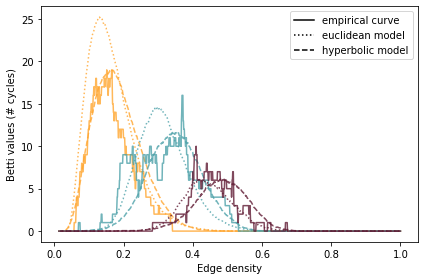

In [9]:
import numpy
import matplotlib.pyplot as plt
COLORS = ['#FFA630', '#4DA1A9', '#611C35']

emp_49 = numpy.load('/Users/fiona/Desktop/membatross/albatross_49/outputs/empirical_betti_curves_mbt_out_49.npz',allow_pickle=True)
eu_49 = numpy.load('/Users/fiona/Desktop/membatross/albatross_49/outputs/euclidean_model_dims_16_epsilon_0.08_mbt_out_49.npz',allow_pickle=True)
# emp_88 = numpy.load('/Users/fiona/Desktop/membatross/albatross_49/outputs/empirical_betti_curves_OPENFIELDm_88_n_75_i_150.npz',allow_pickle=True)
# eu_88 = numpy.load('/Users/fiona/Desktop/membatross/albatross_49/outputs/euclidean_model_dims_8_epsilon_0.14_OPENFIELDm_88_n_75_i_150.npz',allow_pickle=True)
hyp_49 = numpy.load('/Users/fiona/Desktop/membatross/albatross_49/outputs/hyperbolic_model_dims_3_rmax_21_rmin_0.40_epsilon_0.03_mbt_out_49.npz',allow_pickle=True)

emp_49 = [numpy.dstack([emp_49.get(x) for x in filter(lambda x: x.__contains__('%d_' % i),emp_49.keys())]).mean(2).T for i in range(1,4)]
eu_49 = [numpy.dstack([eu_49.get(x) for x in filter(lambda x: x.__contains__('%d_' % i),eu_49.keys())]).mean(2).T for i in range(1,4)]
# emp_88 = [numpy.dstack([emp_88.get(x) for x in filter(lambda x: x.__contains__('%d_' % i),emp_88.keys())]).mean(2).T for i in range(1,4)]
# eu_88 = [numpy.dstack([eu_88.get(x) for x in filter(lambda x: x.__contains__('%d_' % i),eu_88.keys())]).mean(2).T for i in range(1,4)]
hyp_49 = [numpy.dstack([hyp_49.get(x) for x in filter(lambda x: x.__contains__('%d_' % i),hyp_49.keys())]).mean(2).T for i in range(1,4)]


plt.clf()
for i in range(1, 4):
    plt.plot(eu_49[i-1][0,:], eu_49[i-1][1,:], alpha=0.8, color=COLORS[i - 1],
                 linestyle=':')
    plt.plot(hyp_49[i-1][0, :], hyp_49[i-1][1, :], alpha=0.8, color=COLORS[i - 1],
             linestyle='--')
    plt.plot(emp_49[i - 1][0, :], emp_49[i - 1][1, :], alpha=0.8, color=COLORS[i - 1],
             linestyle='-')
#     plt.plot(emp_88[i - 1][0, :], emp_88[i - 1][1, :], alpha=0.8, color=COLORS[i - 1],
#              linestyle='--')
#     plt.text(0.35,25,'n=%d' % 75,size=15)
#     plt.text(0.62, 1, 'n=%d' % 30, size=15)
#     plt.arrow(0.18,10,-.08,20, length_includes_head=True, head_length=1,head_width=.025,color='black')
#     plt.arrow(0.4, 3.5, -.14, 23, length_includes_head=True, head_length=1, head_width=.025, color='black')
#     plt.arrow(0.52, 1, -.13, 14, length_includes_head=True, head_length=1, head_width=.025, color='black')
    plt.ylabel('Betti values (# cycles)')
    plt.xlabel('Edge density')
plt.plot([],[],linestyle='-',color='black',label='empirical curve')
plt.plot([], [], linestyle=':', color='black', label='euclidean model')
plt.plot([], [], linestyle='--', color='black', label='hyperbolic model')
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig('/Users/fiona/Desktop/membatross/albatross_49/outputs/sub_sample_hippo.png', dpi=300)